## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [20]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [22]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


A/B тест проводился в период с 02.01.2021 по 24.01.2021

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [23]:
# Сгруппируем данные по группам, посчитаем количество посещений, 
# сумму покупок и общий чек 
data_by_group = data.groupby('group').agg(
    {'user_id':'count', 'purchase':'sum', 'price':'sum' }).reset_index().rename(
    columns={'user_id':'user_count', 'purchase':'total_purchase', 'price':'total_price'}
    )
data_by_group['total_price'] = data_by_group['total_price'] / 10 ** 6
print('Суммарное количество посещений в группах A и B соответственно:{} '.format(
    (data_by_group[data_by_group['group'] == 'A']['user_count'].loc[0], 
     data_by_group[data_by_group['group'] == 'B']['user_count'].loc[1])))

print('Суммарное количество покупок в группах A и B соответственно:{} '.format(
    (data_by_group[data_by_group['group'] == 'A']['total_purchase'].loc[0], 
     data_by_group[data_by_group['group'] == 'B']['total_purchase'].loc[1])))

print('Сумма всех покупок в группах A и B соответственно:{} '.format(
    (data_by_group[data_by_group['group'] == 'A']['total_price'].loc[0], 
     data_by_group[data_by_group['group'] == 'B']['total_price'].loc[1])))

Суммарное количество посещений в группах A и B соответственно:(147202, 147276) 
Суммарное количество покупок в группах A и B соответственно:(17723, 17514) 
Сумма всех покупок в группах A и B соответственно:(1436.26, 1554.1) 


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?


In [24]:
# Создадим множество пользователей группы А и множество пользователей группы B. 
# Пересечение этих множеств покажет количество пользователей, попавших в обе группы
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
same_users = set_a.intersection(set_b)
print('Количество пользователей, попавших в обе группы: {}'.format(len(same_users)))

Количество пользователей, попавших в обе группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.


In [25]:
# способ 1
new_data = data.set_index('user_id').drop(list(same_users), axis = 0)
new_data.reset_index().head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [26]:
# способ 2
updated_data = data[data['user_id'].apply(lambda x: x not in same_users)]
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

<img src = "/image.png"  width="400" height = "100">
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

Чему на этот раз равно количество посещений сайта в группах А и B?


In [27]:
# Посчитаем количество посещений, сумму покупок и общий чек в обновлённой таблице
data_by_group_upd = updated_data.groupby('group').agg(
    {'user_id':'count', 'purchase':'sum', 'price':'sum' }).reset_index().rename(
    columns={'user_id':'count_visits', 'purchase':'count_purchase', 'price':'sum_price'}
    )
data_by_group_upd

,group,count_visits,count_purchase,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество посещений в обеих группах после очистки данных сопоставимо.
Выборки корректны и готовы к дальнейшему анализу.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [28]:
data_by_group_upd['conversion'] = round(data_by_group_upd['count_purchase'] / 
    data_by_group_upd['count_visits'] * 100, 2)

data_by_group_upd['mean_check'] = (round(data_by_group_upd['sum_price'] / 
    data_by_group_upd['count_purchase'])).astype(int)
data_by_group_upd

,group,count_visits,count_purchase,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076
1,B,145381,17290,1533010000,11.89,88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Выборочная конверсия группы A выше, чем в альтернативной группе B, однако средний чек в группе B выше, для корректной оценки эффективности по конверсии и среднему чеку необходимо дополнить анализ кумулятивными метриками.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


<AxesSubplot: xlabel='group', ylabel='price'>

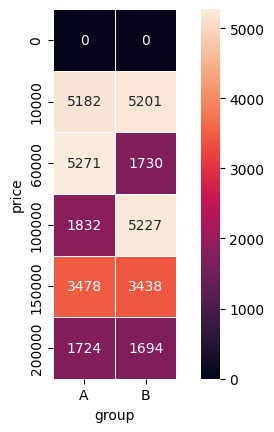

In [29]:
# Создадим сводную табоицу, где в качестве строк укажем цены путевок, 
# в качестве столбцов - группы пользователей,
# вычисляемые значения - количество покупок
pivot_price = updated_data.pivot_table(
    values = 'purchase', 
    index = 'price', 
    columns = 'group', 
    aggfunc = 'sum')
display(pivot_price)
# Визуализируем сводную таблицу в виде тепловой карты
sns.heatmap(pivot_price, 
    annot = True, 
    fmt='1g', 
    square = True, 
    linewidths=0.5, 
    linecolor='white'
            )


Количество проданных туров за 60 000 руб. в группе А - 5 271 шт.            
Количество проданных туров за 60 000 руб. в группе B - 1 730 шт.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Несмотря на меньшую конверсию средний чек в группе B выше за счёт большего числа проданных путёвок по цене 100 000 руб. Продажи в ценовом диапазоне 150 000 - 200 000 руб. и 10 000 руб. сопоставимы, а по цене 60 000 руб. путёвок в группе А продано больше, чем аналогичных в группе В.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [30]:
# Сгруппируем данные по датам и группам.
# Вычислим суммарное число пользователей, количество и сумму покупок.
# Переименуем признаки суммарного числа пользователей, количества и сумму покупок.
data_grouped = updated_data.groupby(['date', 'group']).agg(
    {'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index().rename(
    columns = {'user_id':'count_users', 'purchase':'sum_purchase', 'price':'sum_price'}   
)# Добавим информацию о конверсии по группам
data_grouped['conversion_daily'] = round(data_grouped['sum_purchase'] / 
data_grouped['count_users'] * 100, 2)
# Добавим информацию о ежедневном среднем чеке по группам
data_grouped['avg_check_daily'] = round(data_grouped['sum_price'] / 
data_grouped['sum_purchase']).astype(int)
# Выведем информацию о конверсии и среднем чеке по группам на 03.01.2021
data_grouped[data_grouped['date'] == '2021-01-03'][
    ['group', 'conversion_daily', 
    'avg_check_daily']]

,group,conversion_daily,avg_check_daily
2,A,11.34,82888
3,B,11.39,87480


Показатели конверсии в обеих группах на 03.01.2021 сопоставимы, 
однако средний чек в группе B выше

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [31]:
# Сгруппируем данные по группам и добавим в таблицу кумулятивные метрики по 
# количеству посещений страницы, количеству и сумме покупок по дням
data_grouped['cum_users'] = data_grouped.groupby('group')['count_users'].cumsum()
data_grouped['cum_purchase'] = data_grouped.groupby('group')['sum_purchase'].cumsum()
data_grouped['cum_price'] = data_grouped.groupby('group')['sum_price'].cumsum()
# На основе полученных показателей вычислим кумулятивную конверсию: 
data_grouped['cum_conversion'] = round(data_grouped['cum_purchase'] / 
data_grouped['cum_users'] * 100, 2)
# и кумулятивный средник чек по группам:
data_grouped['cum_avg_check'] = round(data_grouped['cum_price'] / 
data_grouped['cum_purchase']).astype(int)

print('Кумулятивная конверсия в группе B на 20.01.2021: {}'.format(
    data_grouped[(data_grouped['date'] == '2021-01-20') & (data_grouped['group'] == 'B')]
    ['cum_conversion'].iloc[0]
))
print('Кумулятивная средний чек в группе А на 12.01.2021: {}'.format(
    data_grouped[(data_grouped['date'] == '2021-01-12') & (data_grouped['group'] == 'A')]
    ['cum_avg_check'].iloc[0]
))

Кумулятивная конверсия в группе B на 20.01.2021: 11.9
Кумулятивная средний чек в группе А на 12.01.2021: 81492


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

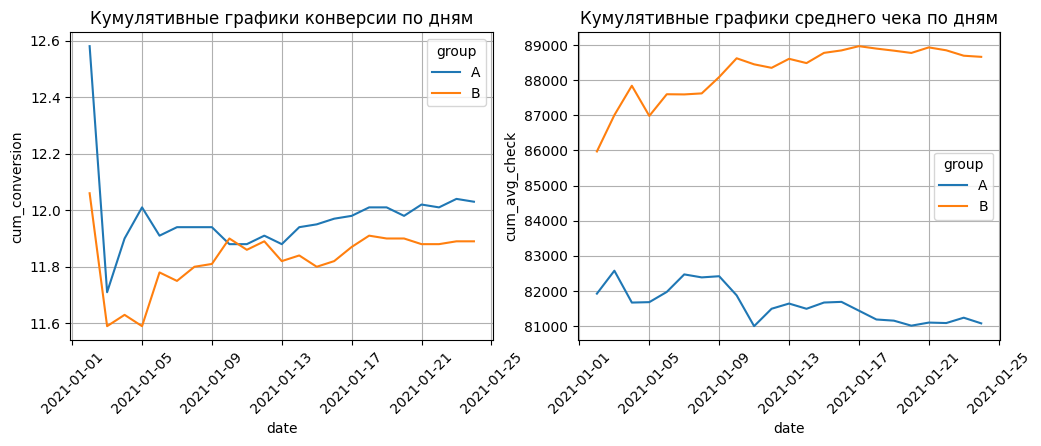

In [32]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
# кумулятивные графики конверсии
sns.lineplot(
    data=data_grouped,
    x='date', 
    y='cum_conversion',
    hue='group',   
    ax=axes[0])
axes[0].set_title('Кумулятивные графики конверсии по дням') # заголовок графика
axes[0].grid(True) #установим сетку
axes[0].xaxis.set_tick_params(rotation=45) #повернем подписи оси x на 45 градусов
# кумулятивные графики среднего чека
sns.lineplot(
    data=data_grouped,
    x='date', 
    y='cum_avg_check',
    hue='group',
    ax=axes[1])
axes[1].set_title('Кумулятивные графики среднего чека по дням')
axes[1].grid(True)
axes[1].xaxis.set_tick_params(rotation=45)

С 6 января графики кумулятивных конверсии и среднего чека можно считать стабилизированными.
Конверсия в группе A выше, чем в группе B на протяжении всего периода исследования за исключением пересечения графиков от 10 января.     
Средний чек в группе B стабильно выше среднего чека группы A на протяжении всего периода исследования.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше, чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [33]:
#Поскольку конверсия является пропорцией, то для проверки 
# статистической значимости подойдёт z-тест.
# Рассчитаем количество наблюдений и успешных операций для каждой из групп:
converted_piv =updated_data.groupby('group')['purchase'].agg(
    ['count', 'sum']).reset_index()
    
display(converted_piv)
alpha = 0.05 # уровень значимости
H0 = 'Конверсии в группах А и B равны' # нулевая гипотеза
H1 = 'Конверсия в группе А больше, чем конверсия в группе B' # альтернативная гипотеза
_, p_value = proportions_ztest(
    count = converted_piv['sum'], # число успехова
    nobs = converted_piv['count'], # общее число наблюдений
    alternative = 'larger'
)
# Выведем значение p-value
print('p-value: {}'.format(round(p_value, 2)))
# Сравниваем полученное p-value с уровнем значимости
if round(p_value, 2) < alpha:
    print('Отвергаем нулевую гипотезу H0: {}'.format(H0))
    print('Принимаем альтернативную гипотезу H1: {}'.format(H1)) 
else:
    print('Принимаем нулевую гипотезу H0: {}'.format(H0))

,group,count,sum
0,A,145307,17487
1,B,145381,17290


p-value: 0.12
Принимаем нулевую гипотезу H0: Конверсии в группах А и B равны


По результатам проведенного статистического теста значение p-value оказалось выше принятого уровня значимости $\alpha$ = 0.05, следовательно, у нас нет оснований принимать альтернативную гипотезу, разницы между конверсией в группах A и B нет.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [34]:
# Создадим функцию для расчёта доверительного интервала для пропорции
def proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (x_p * (1 - x_p) / n)**0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница интервала
    upper_bound = x_p + eps # правая (верхняя) граница интервала
    # выведем границы интервала
    return (round(lower_bound * 100, 2), round(upper_bound * 100, 2))
# Разделим общую таблицу на выборки по группам
a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

conf_int_a = proportions_conf_interval(
    a_data['user_id'].count(), # размер выборки группы A
    a_data['purchase'].mean()) # выборочная пропорция группы A
conf_int_b = proportions_conf_interval(
    b_data['user_id'].count(), # размер выборки группы B
    b_data['purchase'].mean()) # выборочная пропорция группы B
print('Доверительный интервал конверсии для группы A: {}'.format(conf_int_a))
print('Доверительный интервал конверсии для группы B: {}'.format(conf_int_b))

# Создадим функцию для доверительного интервала разницы пропорций
def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2) #z критическое
    # погрешность
    eps = z_crit * (x_p[0] * (1 - x_p[0]) / n[0] + x_p[1] * (1 - x_p[1]) / n[1]) ** 0.5
    lower_bound = diff - eps # левая (нижняя) граница интервала
    upper_bound = diff + eps # правая (верхняя) граница интервала
    return(round(lower_bound * 100, 2), round(upper_bound * 100, 2))
n = [a_data['user_id'].count(), b_data['user_id'].count()] # размер выборок
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()] # выборочные средние
print('Доверительный интервал разности конверсий: {}'.format(
    diff_proportions_conf_interval(n, x_p)))

Доверительный интервал конверсии для группы A: (11.87, 12.2)
Доверительный интервал конверсии для группы B: (11.73, 12.06)
Доверительный интервал разности конверсий: (-0.38, 0.09)


Левый и правый интервалы разности конверсий имеют разные знаки, что подтверждает отсутствие разницы в конверсиях группы A и B.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [35]:
# Для определения характера распредления выборок воспользуемся тестами 
# на нормальность Шапиро
alpha = 0.05 # уровень значимости
# Зададим нулевую (H0) и альтернативную (H1) гипотезы
H0 = 'Выборки в обеих группах имеют номральное распределение'
H1 = 'Распределение в обеих группах, либо в одной из групп отлично от нормального'
# Вычислим p-value по тесту Шапиро для обеих выборок
_, shapiro_a = shapiro(data_grouped[data_grouped['group']=='A']['avg_check_daily']) 
_, shapiro_b = shapiro(data_grouped[data_grouped['group']=='B']['avg_check_daily'])
print('p-value для группы A: {}'.format(round(shapiro_a, 2)))
print('p-value для группы B: {}'.format(round(shapiro_b, 2)))
if round(shapiro_a,2) < alpha or round(shapiro_b,2) < alpha:
    print('Опровергаем нулевую гипотезу H0: {}'.format(H0))
    print('Принимаем альтернативную гипотезу H1: {}'.format(H1)) 
else:
    print('Принимаем нулевую гипотезу H0: {}'.format(H0))


p-value для группы A: 0.25
p-value для группы B: 0.09
Принимаем нулевую гипотезу H0: Выборки в обеих группах имеют номральное распределение


p-value обеих выборок превышает уровень статистической значимости, следовательно, мы не можем отвергнуть нулевую гипотезу и выборки имеют нормальное распределение. 

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [37]:
# Поскольку выборки имеют нормальное распределение, 2 категориальные 
# переменные и 1 зависимую количественную переменную, в качестве сравнительного теста
# выбираем параметрический t-тест
alpha = 0.05
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

a_data = data_grouped[data_grouped['group'] == 'A']
b_data = data_grouped[data_grouped['group'] == 'B']
result = ttest_ind(
    a_data['avg_check_daily'],
    b_data['avg_check_daily'],
    alternative='less'
)
print('p-value: {}'.format(round(result.pvalue, 2)))

if round(result.pvalue, 2) < alpha:
    print('Отвергаем нулевую гипотезу H0: {}'.format(H0))
    print('Принимаем альтернативную гипотезу H1: {}'.format(H1)) 
else:
    print('Принимаем нулевую гипотезу H0: {}'.format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу H0: Ежедневные средние чеки в группах А и B равны
Принимаем альтернативную гипотезу H1: Ежедневный средний чек в группе А меньше чем в группе B


Средний чек в группе B выше, чем в группе A, эта гипотеза подтвердилась сравнительным тестом.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [42]:
def coinf_int_t(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    k = n - 1 # число степеней свободы
    t_crit = -t.ppf(alpha/2, k) # z критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница)
    coinfedence_int = (round(lower_bound), round(upper_bound))# создаём кортеж из
#округлённых границ интервала
    return(coinfedence_int)

a_data = data_grouped[data_grouped['group'] == 'A']
b_data = data_grouped[data_grouped['group'] == 'B']
coinf_int_a = coinf_int_t(
    a_data['count_users'].count(),
    a_data['avg_check_daily'].mean(),
    a_data['avg_check_daily'].std()
)
coinf_int_b = coinf_int_t(
    b_data['count_users'].count(),
    b_data['avg_check_daily'].mean(),
    b_data['avg_check_daily'].std()
)
print('Доверительный интервал среднего чека для группы A: {}'.format(coinf_int_a))
print('Доверительный интервал среднего чека для группы B: {}'.format(coinf_int_b))

Доверительный интервал среднего чека для группы A: (79630, 82308)
Доверительный интервал среднего чека для группы B: (87626, 89526)


## **Общий вывод по результатам A/B-теста**
Доверительные интервалы средних чеков для групп не пересекаются, что с заданной вероятностью подтверждает наши выводы о соотношении средних чеков для групп.
Поскольку конверсия в обеих группах одинаковая, но при этом средний чек в тестовой группе B выше, то можно сделать вывод, что версия дизайна страницы для группы B эффективнее.